In [ ]:
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('pdf', 'svg')

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from umap import UMAP
from umap import plot as uplt
import networkx as nx
import sklearn.mixture as skmx

In [2]:
# The dataframe and its metadata are read into memory.
Expor = pd.read_csv('~/Desktop/OneDrive_1_1-5-2024/Expor_2023_12_15.tsv',sep='\t')
Expor['Image'] = Expor['Image'].str.split('_',expand=True)[4]
Count = pd.read_csv('~/Desktop/OneDrive_1_1-5-2024/Count_per_cell.tsv',sep='\t')
Count['Image'] = Count['Image'].str.split('_',expand=True)[4]
meta = pd.read_csv('~/Desktop/OneDrive_1_1-5-2024/images_list_full.csv',index_col=1)

In [3]:
# The dataframe of interest is normalized.
Means = Expor.filter(like='mean', axis=1)
Means = Means.divide(Means.sum(axis=1), axis=0) * 100

In [4]:
# The dataframe of interest is merged with the metadata.
for clinical_feature in ['SPIT #','FS','SSA','Slide ','Dignosis SjD']:
    Means[clinical_feature] = Expor['Image'].map(meta[clinical_feature].to_dict())

Means = Means.dropna(axis=1)

In [5]:
# The dataframe of interest is downsampled.
min_samples = Means.groupby(Expor['Image']).apply(lambda x: x.shape[0]).min()
downsampled_means = Means.groupby(Expor['Image']).apply(lambda x: x.sample(n=min_samples, random_state=1050))
downsampled_means = downsampled_means.reset_index(level=0)
downsampled_means.shape

(105996, 18)

In [6]:
# Here are the genes that ISH was performed against, along with the clinical metadata.
downsampled_means.columns

Index(['Image', 'Cell: CST3 mean', 'Cell: PIP mean', 'Cell: WFDC2 mean',
       'Cell: BPIFB2 mean', 'Cell: CFTR mean', 'Cell: B2M mean',
       'Cell: ZG16B mean', 'Cell: ISG15 mean', 'Cell: PRR4 mean',
       'Cell: MUC7 mean', 'Cell: CD45 mean', 'Cell: ACTA2 mean', 'SPIT #',
       'FS', 'SSA', 'Slide ', 'Dignosis SjD'],
      dtype='object')

In [7]:
# The design matrix is diagonal: there are no SSA- SjD patients in this dataset.
pd.crosstab(Means['Dignosis SjD'],Means['SSA'])

SSA,+,-
Dignosis SjD,,
0,0,527400
1,469414,0


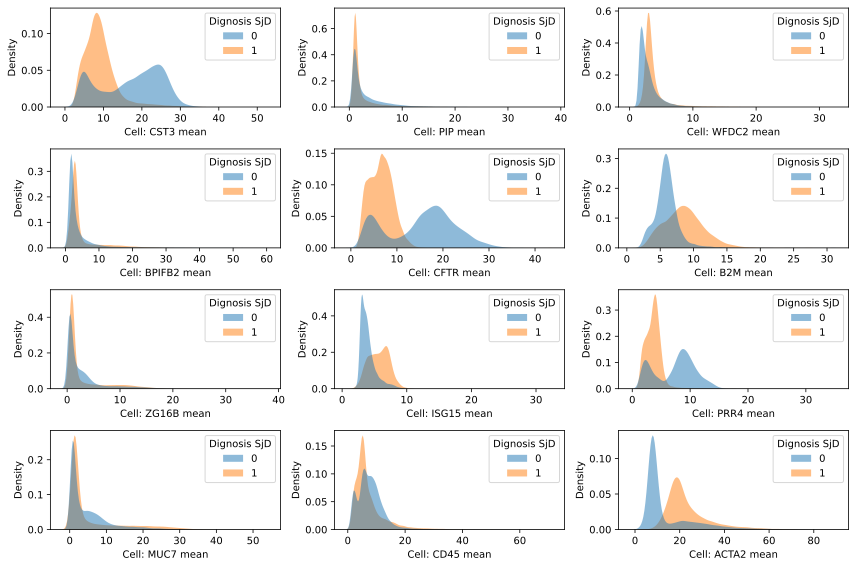

In [8]:
# We plot the distribution of expression values for each gene.
fig, axs = plt.subplots(4, 3, figsize=(12, 8))

i = 0
for column in downsampled_means.columns:
    if 'Cell: ' in column and 'mean' in column:
        row = i // 3
        col = i % 3
        ax = axs[row, col]
        sns.kdeplot(data=downsampled_means, x=column, hue="Dignosis SjD", fill=True, common_norm=False, alpha=.5, linewidth=0, ax=ax)
        i += 1

plt.tight_layout()
plt.show()



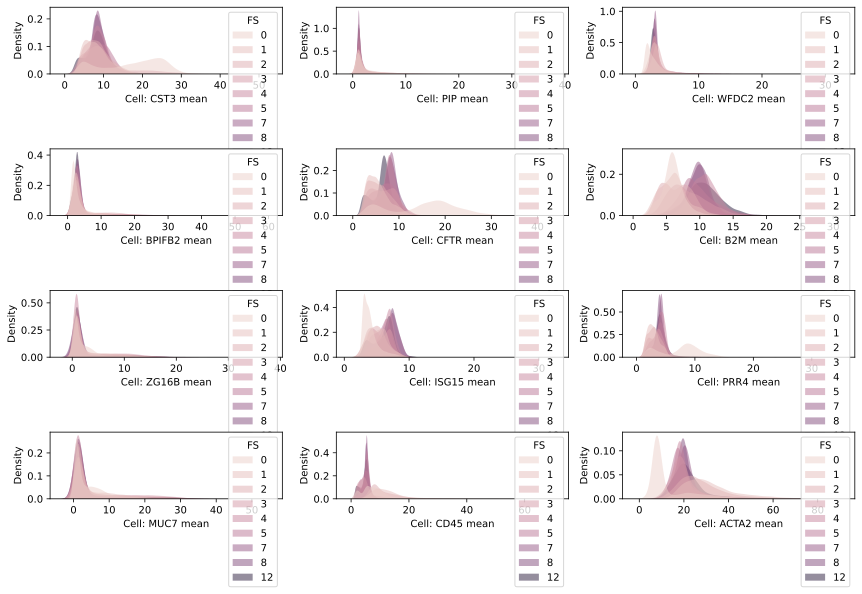

In [9]:
# We plot the distribution of expression values for each gene.
fig, axs = plt.subplots(4, 3, figsize=(12, 8))

i = 0
for column in downsampled_means.columns:
    if 'Cell: ' in column and 'mean' in column:
        row = i // 3
        col = i % 3
        ax = axs[row, col]
        sns.kdeplot(data=downsampled_means, x=column, hue="FS", fill=True, common_norm=False, alpha=.5, linewidth=0, ax=ax)
        i += 1

plt.tight_layout()
plt.show()


In [10]:
# The dataframe is projected onto a lower-dimensional space with UMAP.
X = downsampled_means.drop(['Image','Slide ','Dignosis SjD','SSA','SPIT #'],axis=1)
U = UMAP(metric='cosine',random_state=1050).fit(X)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


<Axes: >

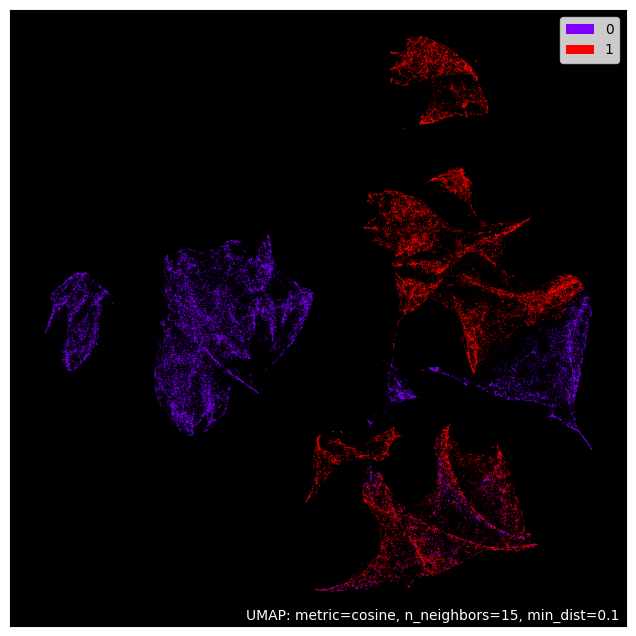

In [11]:
backend_inline.set_matplotlib_formats('png')

uplt.points(U, labels = downsampled_means['Dignosis SjD'], theme='fire')

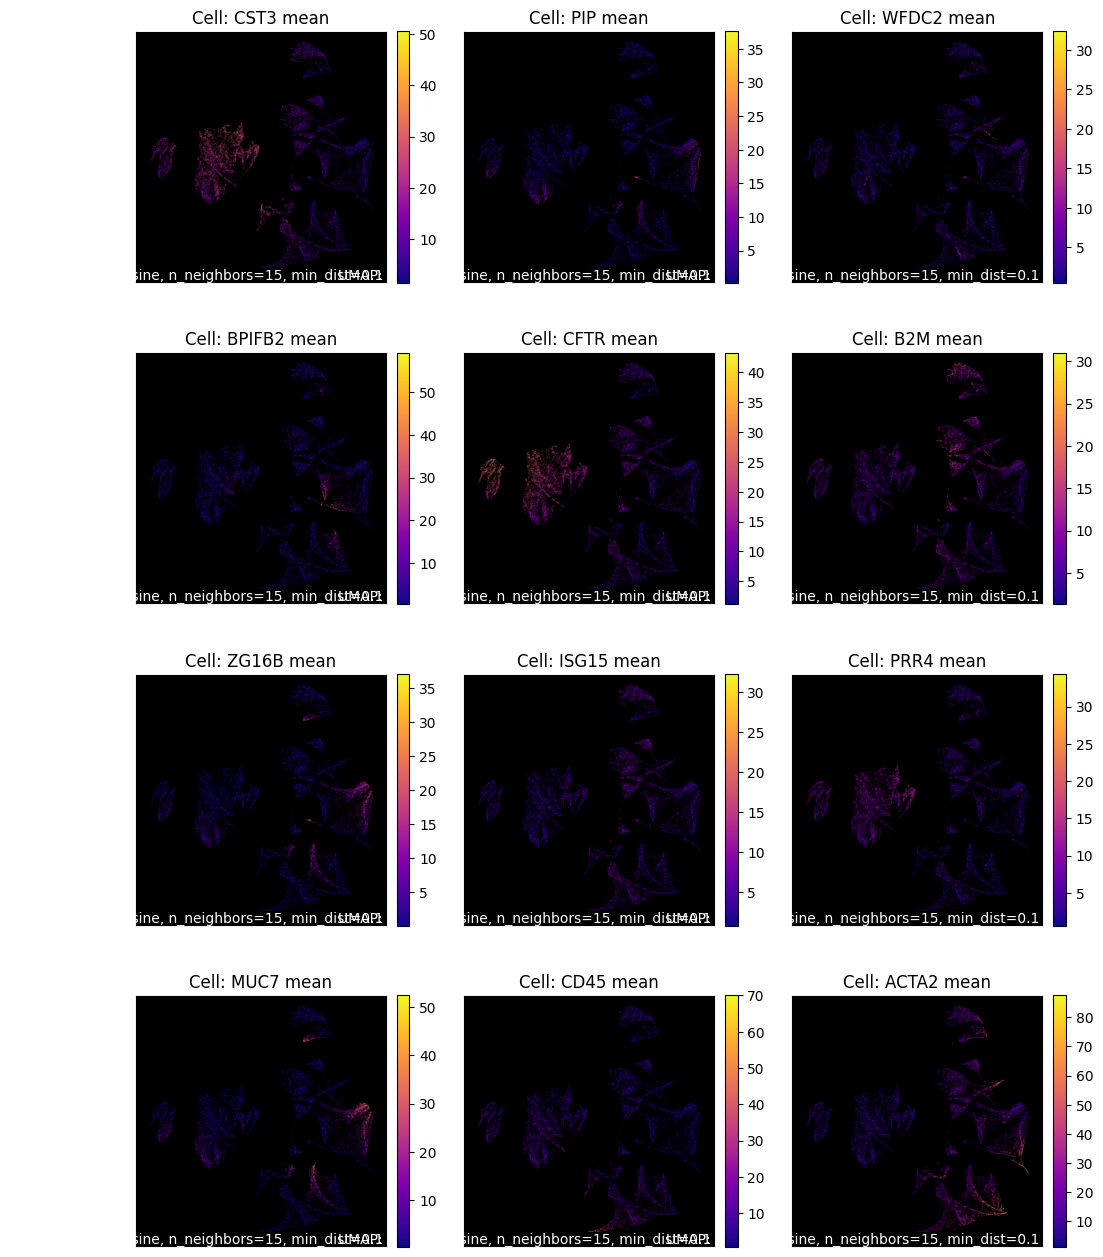

In [12]:
# We plot the distribution of expression values for each gene in the lower-dimensional embeddings.
fig, axs = plt.subplots(4, 3, figsize=(12,16))

i = 0
for column in downsampled_means.columns:
    if 'Cell: ' in column and 'mean' in column:
        row = i // 3
        col = i % 3
        ax = axs[row, col]
        V = downsampled_means[column]
        uplt.points(U, values=V, cmap='plasma', background='black', ax=ax)
        scalar_map = cm.ScalarMappable(cmap='plasma')
        scalar_map.set_clim(V.min(), V.max())
        cbar = fig.colorbar(scalar_map, fraction=0.046, pad=0.04, ax=ax)
        ax.set_title(column)
        i += 1

plt.show()


In [13]:
gmX = skmx.GaussianMixture(n_components=8,random_state=1050).fit_predict(X)
pd.Series(gmX).value_counts()

1    36209
4    15750
5    13710
3    10195
2    10134
0     8654
6     6285
7     5059
Name: count, dtype: int64

<Axes: >

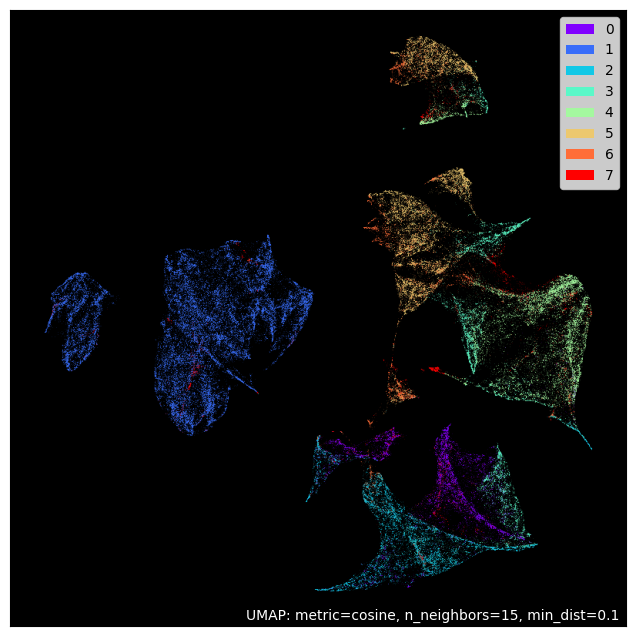

In [14]:
uplt.points(U, labels = gmX, theme='fire')